<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script> 
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3.0.1/es5/tex-mml-chtml.js"></script>

# Figure 2: Various B. burgdorferi strains accumulate PGBb monomers in their culture supernatants during growth.
Code written by Joshua W. McCausland, CJW lab.

This encapsulates analysis and plotting for **Figure 2A-B**. One is to simply plot growth curve measurements, while the other quantifies EICs at each of the growth curve time points. 
- Irnov Irnov completed all experiments.
- Joshua W. McCausland wrote code to plot.
- Both analyzed this data.

## Figure 2A. 
Growth curve of four while type strains of *Borrelia burgdorferi.* Here, we plot the growth curves for the wild type strains. 

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt,ticker,lines
plt.rcParams["font.family"] = "Arial" #Set global font to arial
import glob,os,sys
import re
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
#from functions import *
import warnings
warnings.filterwarnings("ignore")
from multiprocessing import pool
from pymzml.run import Reader
from scipy.signal import find_peaks
from tqdm import tqdm

# This is a pallet of color blind friendly colors.
CB_color_cycle = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

# This is my function to make EICs. I scan mz dataframes for a mass +/- an error (ppm). 
# I return the sum of all peaks which correspond to the matching mzs in our mass window. 
def refine_mass(df,ppm = 20,mass_to_search = 0):
    low_mass = mass_to_search - (ppm*mass_to_search/1e6)
    high_mass = mass_to_search + (ppm*mass_to_search/1e6)
    result = df.apply(lambda row: np.sum(row.peaks[np.where(np.logical_and(row.mz >= low_mass, row.mz <= high_mass))]) if row.peaks[np.where(np.logical_and(row.mz > low_mass, row.mz < high_mass))].shape[0] > 0 else 0,axis=1)
    return result

experiment_directory = '/Volumes/Common/Science communication/Manuscripts/Papers/2025/McCausland et al_2025/Draft_figures/SourceData/Fig2'

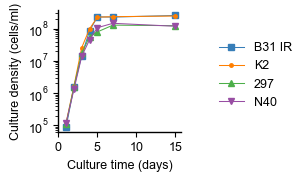

In [2]:
gc = pd.read_csv(f'included_small_datasets/20210419-Cell_density_count_TC.csv')
strains = ["B31 MI 'IR'",'K2','297','N40']
plot_labels = ['B31 IR','K2','297','N40']
marker_shapes = ['s','.','^','v']
CBcolors = ['blue','orange','green','purple']


fig,_ax = plt.subplots(figsize=[1.58,1.59],layout = 'constrained')
for idx,strain in enumerate(strains):
    str = gc[gc.Strain == strain].groupby(['Day']).mean(numeric_only=True)
    err = gc[gc.Strain == strain].groupby(['Day']).std(numeric_only=True)
    _ax.plot(str.index.values,str.Density,f'{marker_shapes[idx]}-',label = plot_labels[idx],color=CB_color_cycle[CBcolors[idx]],markersize=5,linewidth=0.75)
_ax.set_yscale('log')
_ax.set_xticks([0,5,10,15])
_ax.set_yticks([1e5,1e6,1e7,1e8])
_ax.spines[['top','right']].set_visible(False)
_ax.spines[['left','bottom']].set_linewidth(1)
_ax.set_xlabel('Culture time (days)',fontsize=9)
_ax.tick_params(axis='both',labelsize=9)
_ax.set_ylabel('Culture density (cells/ml)',fontsize=9)
_ax.legend(frameon=False,loc='lower right',fontsize=9,bbox_to_anchor=(2,0.1))

## Figure 2B.
mzML files were previously converted to Pandas dataframes. See the code for Figure 1 for details on how this happened.
- Iterate through the mzML-converted pickle files. In each file, integrate the EIC peaks in each file and save them to the dataframe.
- Time windows for each species were determined from plotting EICs separately and determining the window that encapsulates the highest peaks.

In [8]:
species_to_plot = ['ZAEOAAG','ZAEOG','Z','AEOAAG','AEOAA']

# this is the reference dataframe that Irnov created.
reference_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)].set_index('Species')

masses = {
    'ZAEOAAG': [12.7,13.8],
    'ZAEOG': [11.8,12.7],
    'Z': [9.8,10.5],
    'AEOAAG': [1.95,2.2],
    'AEOAA': [1.5,2.1]
}

ms_files = glob.glob(f'{experiment_directory}/dataframes/ms_dataframes/*.pkl')
file = ms_files[0]
integrated_df = pd.DataFrame()
idx = -1
for file in tqdm(ms_files):
    rundf = pd.read_pickle(file)
    filename = os.path.basename(file).removesuffix('.pkl')
    condition = filename.split('_')[0]
    if condition == 'B31IR':
        condition = 'B31 IR'
    day = int(filename.split('_')[1][1:])
    rep = int(filename.split('_')[2])
    for _species,time_window in masses.items():
        rundf[_species] = refine_mass(rundf,mass_to_search=reference_df['mz_plus_1'].loc[_species])
        integrated_peak = rundf[rundf.time.between(time_window[0],time_window[1])][_species].sum()
        tempdf = pd.DataFrame({
            'Condition': condition,
            'Day': day,
            'Rep': rep,
            'Mass': reference_df['mz_plus_1'].loc[_species],
            'species': _species,
            'Peak': integrated_peak},index = [idx])
        idx+=1
        integrated_df = pd.concat([integrated_df,tempdf])
integrated_df

100%|██████████| 62/62 [02:36<00:00,  2.52s/it]


,Condition,Day,Rep,Mass,species,Peak
-1,297,15,1,992.441860,ZAEOAAG,212376.0
0,297,15,1,850.367634,ZAEOG,85064.0
1,297,15,1,479.187150,Z,443371.0
2,297,15,1,532.272550,AEOAAG,338534.0
3,297,15,1,475.251087,AEOAA,136668.0
...,...,...,...,...,...,...
304,N40,7,3,992.441860,ZAEOAAG,320772.0
305,N40,7,3,850.367634,ZAEOG,92122.0
306,N40,7,3,479.187150,Z,288222.0
307,N40,7,3,532.272550,AEOAAG,196606.0


Iterate through the PG species and plot them on each axis. 

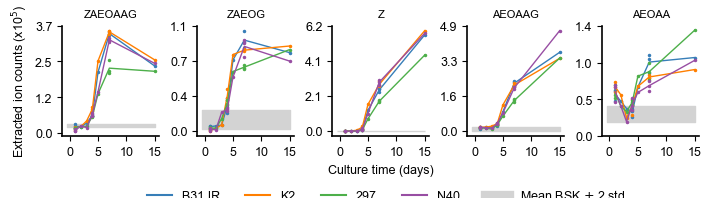

In [10]:
strains = ['B31 IR','K2','297','N40']
CBcolors = ['blue','orange','green','purple']
species_to_plot = ['ZAEOAAG','ZAEOG','Z','AEOAAG','AEOAA']

def y_fmt(x, y):
    return f'{(x/1e5):<2.1f}'.format(x).split('e')[0]

fig,axs = plt.subplots(ncols = 5,figsize=[7,1.75],layout='constrained')
for _species,ax in zip(species_to_plot,axs):
    temp_df = integrated_df[integrated_df.species == _species]

    for strain,_color in zip(strains,CBcolors):
        temp_df_strain = temp_df[temp_df.Condition == strain]
        ax.plot(temp_df_strain.Day,temp_df_strain.Peak,'.',markersize=3,color=CB_color_cycle[_color])
        ax.plot(np.sort(temp_df_strain.Day.unique()),temp_df_strain.groupby('Day').Peak.mean(),'-',color = CB_color_cycle[_color],linewidth = 1,label = strain)

    bsk_temp_df = integrated_df[(integrated_df.species == _species) & (integrated_df.Condition == 'BSK')]
    ymean = bsk_temp_df.Peak.mean()
    ystd = bsk_temp_df.Peak.std()
    ax.fill_between([-0.5,15],ymean+ystd*2,ymean-ystd*2,color = 'lightgray',label='Std. Deviation')
    ylims = ax.get_ylim()
    y_spacing = np.linspace(0,ylims[1],4)
    ax.set_yticks(y_spacing)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    ax.spines[['top','right']].set_visible(False)
    ax.spines[['bottom','left']].set_linewidth(1.2)
    ax.tick_params(axis='both',labelsize=9)
    ax.set_title(_species,fontsize=8)
    ax.set_xticks([0,5,10,15])
axs[0].set_ylabel('Extracted ion counts (x10$^5$)',fontsize=9)
axs[2].set_xlabel('Culture time (days)',fontsize=9)

handles = axs[2].get_lines()
labels = []
for idx,_color in zip(strains,CBcolors):
    labels.append((lines.Line2D([0],[0],color=CB_color_cycle[_color]),idx))
labels.append((lines.Line2D([0],[0],color='lightgray',linewidth=6),'Mean BSK $\pm$ 2 std.'))
fig.legend(*zip(*labels), loc=(0.2,-0.045),frameon=False,fontsize=9,ncols=5)